<a href="https://colab.research.google.com/github/vivekgautamgv/Python-For-Finance/blob/main/strategy_finchat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy-financial

In [ ]:
!pip install numpy_financial

Enter your financial goal amount: 8000
Enter goal timeline in months: 6
Enter your minimum risk tolerance (0-6): 4
Enter your maximum risk tolerance (0-6): 6
Enter your current monthly income: 5000
Enter your monthly expenses: 4200
Enter your previous savings: 500


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Initial capital: 1300.00
Capital after investments in 6 months: 7930.97
How close to target: 99.14%

Suggested Mutual Funds and SIP Amount:
Scheme: Quant Infrastructure Fund, 1-Year Return: 5.6%, SIP Amount: ₹147.94
Scheme: Templeton India Equity Income Fund, 1-Year Return: 8.3%, SIP Amount: ₹219.27
Scheme: SBI Conservative Hybrid Fund, 1-Year Return: 6.2%, SIP Amount: ₹163.79


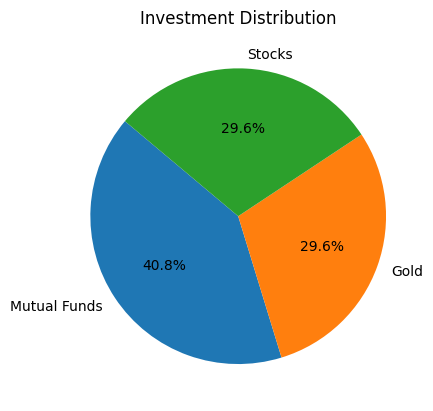

In [14]:
#update1 Changes:
# Monthly SIP Calculation: Based on the user's total monthly savings, we will suggest how much they should invest in mutual funds, gold, and stocks. The SIP for mutual funds will be based on the allocation and expected returns to meet the financial goal.
# Total Investment Including SIPs: We will calculate how the user's monthly SIPs contribute to achieving the financial goal over the timeline.
# Suggested SIPs for Mutual Funds: The SIP amount for each suggested mutual fund will be calculated based on the proportion of the mutual fund investment from the total savings.
import pandas as pd
import numpy as np
import yfinance as yf
import numpy_financial as npf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load Mutual Fund Data
mutual_fund_data = pd.read_csv('/content/sample_data/comprehensive_mutual_funds_data.csv')

# Step 1: Get user input
def get_user_input():
    financial_goal = float(input("Enter your financial goal amount: "))
    goal_timeline_months = int(input("Enter goal timeline in months: "))
    risk_min = int(input("Enter your minimum risk tolerance (0-6): "))
    risk_max = int(input("Enter your maximum risk tolerance (0-6): "))
    monthly_income = float(input("Enter your current monthly income: "))
    monthly_expenses = float(input("Enter your monthly expenses: "))
    previous_savings = float(input("Enter your previous savings: "))

    return {
        "financial_goal": financial_goal,
        "goal_timeline_months": goal_timeline_months,
        "risk_min": risk_min,
        "risk_max": risk_max,
        "monthly_income": monthly_income,
        "monthly_expenses": monthly_expenses,
        "previous_savings": previous_savings
    }

# Step 2: Filter mutual funds based on risk tolerance
def filter_mutual_funds(risk_min, risk_max):
    return mutual_fund_data[(mutual_fund_data['risk_level'] >= risk_min) &
                            (mutual_fund_data['risk_level'] <= risk_max)]

# Step 3: Select top 3 mutual funds
def select_top_mutual_funds(filtered_funds):
    return filtered_funds.sort_values(by='sharpe', ascending=False).head(3)

# Step 4: Fetch live data for gold and stocks
def fetch_live_data():
    gold_data = yf.download("GC=F", start="2022-01-01", end="2023-01-01")
    stock_data = yf.download("^NSEI", period="6mo", interval="1d")  # NSE Nifty 50 index
    return gold_data, stock_data

# Step 5: Calculate expected returns
def calculate_expected_returns(top_funds, gold_data, stock_data):
    stock_returns = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0] * 100
    gold_returns = (gold_data['Close'].iloc[-1] - gold_data['Close'].iloc[0]) / gold_data['Close'].iloc[0] * 100
    mutual_fund_returns = top_funds['returns_1yr'].mean()

    return mutual_fund_returns, stock_returns, gold_returns

# Step 6: Dynamic SIP Allocation based on savings
def sip_allocation(total_savings):
    mutual_fund_sip = np.random.uniform(0.40, 0.50) * total_savings
    remaining_savings = total_savings - mutual_fund_sip
    gold_sip = remaining_savings * 0.50
    stock_sip = remaining_savings * 0.50
    return mutual_fund_sip, gold_sip, stock_sip

# Step 7: Dynamic investment allocation and return calculation
def dynamic_investment_plan(user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns):
    monthly_savings = user_input['monthly_income'] - user_input['monthly_expenses']
    total_savings = monthly_savings + user_input['previous_savings']

    # Allocate SIPs based on savings
    mutual_fund_sip, gold_sip, stock_sip = sip_allocation(total_savings)

    # Calculate future value from monthly SIPs
    months = user_input['goal_timeline_months']
    mutual_fund_future_value = npf.fv(mutual_fund_returns / 100 / 12, months, -mutual_fund_sip, 0)
    gold_future_value = npf.fv(gold_returns / 100 / 12, months, -gold_sip, 0)
    stock_future_value = npf.fv(stock_returns / 100 / 12, months, -stock_sip, 0)

    # Total future value
    total_future_value = mutual_fund_future_value + gold_future_value + stock_future_value
    return total_future_value, mutual_fund_sip, gold_sip, stock_sip

# Step 8: Generate a financial plan
def generate_financial_plan(user_input):
    # Filter mutual funds by risk and select top 3
    filtered_funds = filter_mutual_funds(user_input['risk_min'], user_input['risk_max'])
    top_funds = select_top_mutual_funds(filtered_funds)

    # Fetch gold and stock data
    gold_data, stock_data = fetch_live_data()

    # Calculate expected returns
    mutual_fund_returns, stock_returns, gold_returns = calculate_expected_returns(top_funds, gold_data, stock_data)

    # Get the future value based on dynamic allocation
    total_future_value, mf_sip, gold_sip, stock_sip = dynamic_investment_plan(
        user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns)

    # Display financial plan results
    print(f"\nInitial capital: {user_input['monthly_income'] - user_input['monthly_expenses'] + user_input['previous_savings']:.2f}")
    print(f"Capital after investments in {user_input['goal_timeline_months']} months: {total_future_value:.2f}")
    print(f"How close to target: {total_future_value / user_input['financial_goal'] * 100:.2f}%")

    # Display suggested mutual funds with SIPs
    print("\nSuggested Mutual Funds and SIP Amount:")
    for idx, row in top_funds.iterrows():
        fund_allocation_percentage = row['returns_1yr'] / top_funds['returns_1yr'].sum()  # Distribute based on returns
        sip_amount = fund_allocation_percentage * mf_sip
        print(f"Scheme: {row['scheme_name']}, 1-Year Return: {row['returns_1yr']}%, SIP Amount: ₹{sip_amount:.2f}")

    # Visualization: Pie chart for investment distribution
    labels = ['Mutual Funds', 'Gold', 'Stocks']
    sizes = [mf_sip, gold_sip, stock_sip]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Investment Distribution')
    plt.show()

# Main function
def main():
    user_input = get_user_input()
    generate_financial_plan(user_input)

if __name__ == "__main__":
    main()


Enter your financial goal amount: 8000
Enter goal timeline in months: 6
Enter your minimum risk tolerance (0-6): 5
Enter your maximum risk tolerance (0-6): 6
Enter your current monthly income: 5000
Enter your monthly expenses: 4500
Enter your previous savings: 100


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Initial capital: 600.00
Capital after investments in 6 months: 3661.17
How close to target: 45.76%

Suggested Mutual Funds and SIP Allocation:
Scheme: Quant Infrastructure Fund, SIP Allocation: 12.17 per month, Sharpe Ratio: 2.3
Scheme: Templeton India Equity Income Fund, SIP Allocation: 12.17 per month, Sharpe Ratio: 2.26
Scheme: SBI Conservative Hybrid Fund, SIP Allocation: 12.17 per month, Sharpe Ratio: 2.23


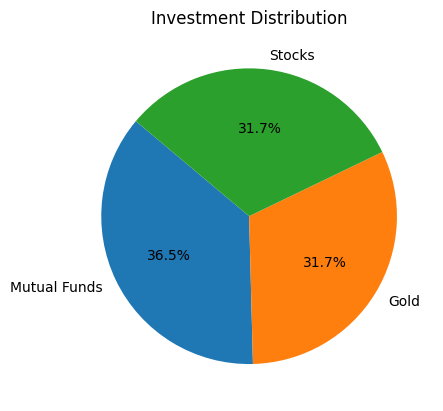

In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import numpy_financial as npf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load Mutual Fund Data
mutual_fund_data = pd.read_csv('/content/sample_data/comprehensive_mutual_funds_data.csv')

# Step 1: Get user input
def get_user_input():
    financial_goal = float(input("Enter your financial goal amount: "))
    goal_timeline_months = int(input("Enter goal timeline in months: "))
    risk_min = int(input("Enter your minimum risk tolerance (0-6): "))
    risk_max = int(input("Enter your maximum risk tolerance (0-6): "))
    monthly_income = float(input("Enter your current monthly income: "))
    monthly_expenses = float(input("Enter your monthly expenses: "))
    previous_savings = float(input("Enter your previous savings: "))

    return {
        "financial_goal": financial_goal,
        "goal_timeline_months": goal_timeline_months,
        "risk_min": risk_min,
        "risk_max": risk_max,
        "monthly_income": monthly_income,
        "monthly_expenses": monthly_expenses,
        "previous_savings": previous_savings
    }

# Step 2: Filter mutual funds based on risk tolerance
def filter_mutual_funds(risk_min, risk_max):
    return mutual_fund_data[(mutual_fund_data['risk_level'] >= risk_min) &
                            (mutual_fund_data['risk_level'] <= risk_max)]

# Step 3: Select top 3 mutual funds
def select_top_mutual_funds(filtered_funds):
    return filtered_funds.sort_values(by='sharpe', ascending=False).head(3)

# Step 4: Fetch live data for gold and stocks
def fetch_live_data():
    gold_data = yf.download("GC=F", start="2022-01-01", end="2023-01-01")
    stock_data = yf.download("^NSEI", period="6mo", interval="1d")  # NSE Nifty 50 index
    return gold_data, stock_data

# Step 5: Calculate expected returns
def calculate_expected_returns(top_funds, gold_data, stock_data):
    stock_returns = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0] * 100
    gold_returns = (gold_data['Close'].iloc[-1] - gold_data['Close'].iloc[0]) / gold_data['Close'].iloc[0] * 100
    mutual_fund_returns = top_funds['returns_1yr'].mean()

    return mutual_fund_returns, stock_returns, gold_returns

# Step 6: Random distribution to mutual funds (40-50%)
def random_distribution_to_mutual_funds(monthly_savings):
    mutual_fund_allocation = np.random.uniform(0.40, 0.50) * monthly_savings
    return mutual_fund_allocation

# Step 7: Dynamic investment allocation and return calculation
def dynamic_investment_plan(user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns):
    # Calculate total monthly savings
    monthly_savings = user_input['monthly_income'] - user_input['monthly_expenses']
    total_savings = monthly_savings + user_input['previous_savings']

    # Allocate random percentage to mutual funds
    mutual_fund_investment = random_distribution_to_mutual_funds(monthly_savings)

    # Allocate remaining savings to gold and stocks
    remaining_savings = total_savings - mutual_fund_investment
    gold_investment = remaining_savings * 0.50  # 50% of remaining to gold
    stock_investment = remaining_savings * 0.50  # 50% of remaining to stocks

    # Calculate future values for each investment
    months = user_input['goal_timeline_months']
    mutual_fund_future_value = npf.fv(mutual_fund_returns / 100 / 12, months, -mutual_fund_investment, 0)
    gold_future_value = npf.fv(gold_returns / 100 / 12, months, -gold_investment, 0)
    stock_future_value = npf.fv(stock_returns / 100 / 12, months, -stock_investment, 0)

    # Total future value
    total_future_value = mutual_fund_future_value + gold_future_value + stock_future_value
    return total_future_value, mutual_fund_investment, gold_investment, stock_investment

# Step 8: Calculate monthly SIP for mutual funds
def calculate_sip_for_mutual_funds(user_input, top_funds, mutual_fund_investment):
    sip_per_month = mutual_fund_investment / user_input['goal_timeline_months']
    sip_distribution = sip_per_month / len(top_funds)
    return sip_distribution

# Step 9: Generate a financial plan
def generate_financial_plan(user_input):
    # Filter mutual funds by risk and select top 3
    filtered_funds = filter_mutual_funds(user_input['risk_min'], user_input['risk_max'])
    top_funds = select_top_mutual_funds(filtered_funds)

    # Fetch gold and stock data
    gold_data, stock_data = fetch_live_data()

    # Calculate expected returns
    mutual_fund_returns, stock_returns, gold_returns = calculate_expected_returns(top_funds, gold_data, stock_data)

    # Get the future value based on dynamic allocation
    total_future_value, mf_investment, gold_investment, stock_investment = dynamic_investment_plan(
        user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns)

    # Calculate SIP for mutual funds
    sip_distribution = calculate_sip_for_mutual_funds(user_input, top_funds, mf_investment)

    # Display financial plan results
    print(f"\nInitial capital: {user_input['monthly_income'] - user_input['monthly_expenses'] + user_input['previous_savings']:.2f}")
    print(f"Capital after investments in {user_input['goal_timeline_months']} months: {total_future_value:.2f}")
    print(f"How close to target: {total_future_value / user_input['financial_goal'] * 100:.2f}%")

    # Display suggested mutual funds and SIP allocation
    print("\nSuggested Mutual Funds and SIP Allocation:")
    for idx, row in top_funds.iterrows():
        print(f"Scheme: {row['scheme_name']}, SIP Allocation: {sip_distribution:.2f} per month, Sharpe Ratio: {row['sharpe']}")

    # Visualization: Pie chart for investment distribution
    labels = ['Mutual Funds', 'Gold', 'Stocks']
    sizes = [mf_investment, gold_investment, stock_investment]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Investment Distribution')
    plt.show()

# Main function
def main():
    user_input = get_user_input()
    generate_financial_plan(user_input)

if __name__ == "__main__":
    main()


Enter your financial goal amount: 78000
Enter goal timeline in months: 12
Enter your minimum risk tolerance (0-6): 4
Enter your maximum risk tolerance (0-6): 6
Enter your current monthly income: 50000
Enter your monthly expenses: 47000
Enter your previous savings: 0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



--- Investment Breakdown ---
Mutual Funds Investment (Monthly SIP): ₹1435.50
Gold Investment (Monthly SIP): ₹782.25
Stock Investment (Monthly SIP): ₹782.25
Mutual Funds Future Value: ₹17764.93
Gold Future Value: ₹9435.70
Stock Future Value: ₹10130.14

Initial capital: 3000.00
Capital after investments in 12 months: ₹37330.77
How close to target: 47.86%

Suggested Mutual Funds and SIP Amount:
Scheme: Quant Infrastructure Fund, 1-Year Return: 5.6%, SIP Amount: ₹399.94
Scheme: Templeton India Equity Income Fund, 1-Year Return: 8.3%, SIP Amount: ₹592.77
Scheme: SBI Conservative Hybrid Fund, 1-Year Return: 6.2%, SIP Amount: ₹442.79


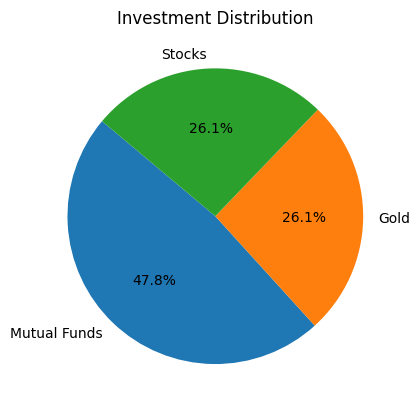

In [19]:
# Detailed Breakdown: The breakdown of the investments is displayed,

import pandas as pd
import numpy as np
import yfinance as yf
import numpy_financial as npf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load Mutual Fund Data
mutual_fund_data = pd.read_csv('/content/sample_data/comprehensive_mutual_funds_data.csv')

# Step 1: Get user input
def get_user_input():
    financial_goal = float(input("Enter your financial goal amount: "))
    goal_timeline_months = int(input("Enter goal timeline in months: "))
    risk_min = int(input("Enter your minimum risk tolerance (0-6): "))
    risk_max = int(input("Enter your maximum risk tolerance (0-6): "))
    monthly_income = float(input("Enter your current monthly income: "))
    monthly_expenses = float(input("Enter your monthly expenses: "))
    previous_savings = float(input("Enter your previous savings: "))

    return {
        "financial_goal": financial_goal,
        "goal_timeline_months": goal_timeline_months,
        "risk_min": risk_min,
        "risk_max": risk_max,
        "monthly_income": monthly_income,
        "monthly_expenses": monthly_expenses,
        "previous_savings": previous_savings
    }

# Step 2: Filter mutual funds based on risk tolerance
def filter_mutual_funds(risk_min, risk_max):
    return mutual_fund_data[(mutual_fund_data['risk_level'] >= risk_min) &
                            (mutual_fund_data['risk_level'] <= risk_max)]

# Step 3: Select top 3 mutual funds
def select_top_mutual_funds(filtered_funds):
    return filtered_funds.sort_values(by='sharpe', ascending=False).head(3)

# Step 4: Fetch live data for gold and stocks
def fetch_live_data():
    gold_data = yf.download("GC=F", start="2022-01-01", end="2023-01-01")
    stock_data = yf.download("^NSEI", period="6mo", interval="1d")  # NSE Nifty 50 index
    return gold_data, stock_data

# Step 5: Calculate expected returns
def calculate_expected_returns(top_funds, gold_data, stock_data):
    stock_returns = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0] * 100
    gold_returns = (gold_data['Close'].iloc[-1] - gold_data['Close'].iloc[0]) / gold_data['Close'].iloc[0] * 100
    mutual_fund_returns = top_funds['returns_1yr'].mean()

    return mutual_fund_returns, stock_returns, gold_returns

# Step 6: Dynamic SIP Allocation based on savings
def sip_allocation(total_savings):
    mutual_fund_sip = np.random.uniform(0.40, 0.50) * total_savings
    remaining_savings = total_savings - mutual_fund_sip
    gold_sip = remaining_savings * 0.50
    stock_sip = remaining_savings * 0.50
    return mutual_fund_sip, gold_sip, stock_sip

# Step 7: Dynamic investment allocation and return calculation
def dynamic_investment_plan(user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns):
    monthly_savings = user_input['monthly_income'] - user_input['monthly_expenses']
    total_savings = monthly_savings + user_input['previous_savings']

    # Allocate SIPs based on savings
    mutual_fund_sip, gold_sip, stock_sip = sip_allocation(total_savings)

    # Calculate future value from monthly SIPs
    months = user_input['goal_timeline_months']
    mutual_fund_future_value = npf.fv(mutual_fund_returns / 100 / 12, months, -mutual_fund_sip, 0)
    gold_future_value = npf.fv(gold_returns / 100 / 12, months, -gold_sip, 0)
    stock_future_value = npf.fv(stock_returns / 100 / 12, months, -stock_sip, 0)

    # Total future value
    total_future_value = mutual_fund_future_value + gold_future_value + stock_future_value

    # Show breakdown
    print(f"\n--- Investment Breakdown ---")
    print(f"Mutual Funds Investment (Monthly SIP): ₹{mutual_fund_sip:.2f}")
    print(f"Gold Investment (Monthly SIP): ₹{gold_sip:.2f}")
    print(f"Stock Investment (Monthly SIP): ₹{stock_sip:.2f}")
    print(f"Mutual Funds Future Value: ₹{mutual_fund_future_value:.2f}")
    print(f"Gold Future Value: ₹{gold_future_value:.2f}")
    print(f"Stock Future Value: ₹{stock_future_value:.2f}")

    return total_future_value, mutual_fund_sip, gold_sip, stock_sip

# Step 8: Generate a financial plan
def generate_financial_plan(user_input):
    # Filter mutual funds by risk and select top 3
    filtered_funds = filter_mutual_funds(user_input['risk_min'], user_input['risk_max'])
    top_funds = select_top_mutual_funds(filtered_funds)

    # Fetch gold and stock data
    gold_data, stock_data = fetch_live_data()

    # Calculate expected returns
    mutual_fund_returns, stock_returns, gold_returns = calculate_expected_returns(top_funds, gold_data, stock_data)

    # Get the future value based on dynamic allocation
    total_future_value, mf_sip, gold_sip, stock_sip = dynamic_investment_plan(
        user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns)

    # Display financial plan results
    print(f"\nInitial capital: {user_input['monthly_income'] - user_input['monthly_expenses'] + user_input['previous_savings']:.2f}")
    print(f"Capital after investments in {user_input['goal_timeline_months']} months: ₹{total_future_value:.2f}")
    print(f"How close to target: {total_future_value / user_input['financial_goal'] * 100:.2f}%")

    # Display suggested mutual funds with SIPs
    print("\nSuggested Mutual Funds and SIP Amount:")
    for idx, row in top_funds.iterrows():
        fund_allocation_percentage = row['returns_1yr'] / top_funds['returns_1yr'].sum()  # Distribute based on returns
        sip_amount = fund_allocation_percentage * mf_sip
        print(f"Scheme: {row['scheme_name']}, 1-Year Return: {row['returns_1yr']}%, SIP Amount: ₹{sip_amount:.2f}")

    # Visualization: Pie chart for investment distribution
    labels = ['Mutual Funds', 'Gold', 'Stocks']
    sizes = [mf_sip, gold_sip, stock_sip]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Investment Distribution')
    plt.show()

# Main function
def main():
    user_input = get_user_input()
    generate_financial_plan(user_input)

if __name__ == "__main__":
    main()


In [2]:
pip install numpy_financial


Enter your financial goal amount: 50000
Enter goal timeline in months: 5
Enter your minimum risk tolerance (0-6): 5
Enter your maximum risk tolerance (0-6): 6
Enter your current monthly income: 45000
Enter your monthly expenses: 40000
Enter your previous savings: 0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



--- Monthly Investment Breakdown ---
Monthly Savings: ₹5000.00
Mutual Funds SIP: ₹2065.80
Gold Investment: ₹1467.10
Stock Investment: ₹1467.10
Total Future Value: ₹47055.82

Initial capital: 0.00
Capital after 5 months of investments: ₹47055.82
How close to target: 94.11%


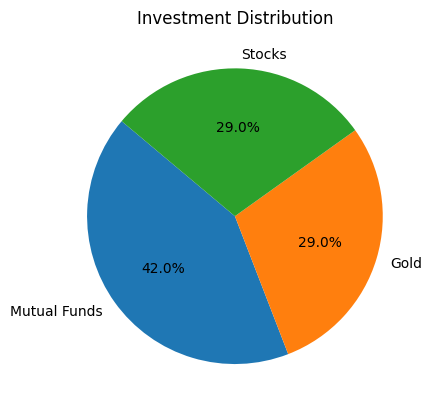

In [6]:
# Updated Breakdown: Now accounts for monthly SIP in Mutual Funds and lump sum investments in stocks and gold

import pandas as pd
import numpy as np
import yfinance as yf
import numpy_financial as npf
import matplotlib.pyplot as plt

# Load Mutual Fund Data
mutual_fund_data = pd.read_csv('/content/sample_data/comprehensive_mutual_funds_data.csv')

# Step 1: Get user input
def get_user_input():
    financial_goal = float(input("Enter your financial goal amount: "))
    goal_timeline_months = int(input("Enter goal timeline in months: "))
    risk_min = int(input("Enter your minimum risk tolerance (0-6): "))
    risk_max = int(input("Enter your maximum risk tolerance (0-6): "))
    monthly_income = float(input("Enter your current monthly income: "))
    monthly_expenses = float(input("Enter your monthly expenses: "))
    previous_savings = float(input("Enter your previous savings: "))

    return {
        "financial_goal": financial_goal,
        "goal_timeline_months": goal_timeline_months,
        "risk_min": risk_min,
        "risk_max": risk_max,
        "monthly_income": monthly_income,
        "monthly_expenses": monthly_expenses,
        "previous_savings": previous_savings
    }

# Step 2: Filter mutual funds based on risk tolerance
def filter_mutual_funds(risk_min, risk_max):
    return mutual_fund_data[(mutual_fund_data['risk_level'] >= risk_min) &
                            (mutual_fund_data['risk_level'] <= risk_max)]

# Step 3: Select top 3 mutual funds
def select_top_mutual_funds(filtered_funds):
    return filtered_funds.sort_values(by='sharpe', ascending=False).head(3)

# Step 4: Fetch live data for gold and stocks
def fetch_live_data():
    gold_data = yf.download("GC=F", start="2022-01-01", end="2023-01-01")
    stock_data = yf.download("^NSEI", period="6mo", interval="1d")  # NSE Nifty 50 index
    return gold_data, stock_data

# Step 5: Calculate expected returns
def calculate_expected_returns(top_funds, gold_data, stock_data):
    stock_returns = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0] * 100
    gold_returns = (gold_data['Close'].iloc[-1] - gold_data['Close'].iloc[0]) / gold_data['Close'].iloc[0] * 100
    mutual_fund_returns = top_funds['returns_1yr'].mean()

    return mutual_fund_returns, stock_returns, gold_returns

# Step 6: Dynamic SIP Allocation for Mutual Funds and lump sum for stocks/gold
def sip_allocation(monthly_savings):
    mutual_fund_sip = np.random.uniform(0.40, 0.50) * monthly_savings
    remaining_savings = monthly_savings - mutual_fund_sip
    gold_investment = remaining_savings * 0.50
    stock_investment = remaining_savings * 0.50
    return mutual_fund_sip, gold_investment, stock_investment

# Step 7: Calculate future value of lump sum investments and monthly SIPs
def calculate_future_value(month, mutual_fund_sip, gold_investment, stock_investment, mutual_fund_returns, gold_returns, stock_returns):
    mutual_fund_future_value = npf.fv(mutual_fund_returns / 100 / 12, month, -mutual_fund_sip, 0)
    gold_future_value = npf.fv(gold_returns / 100 / 12, month, 0, -gold_investment)
    stock_future_value = npf.fv(stock_returns / 100 / 12, month, 0, -stock_investment)

    total_future_value = mutual_fund_future_value + gold_future_value + stock_future_value
    return total_future_value

# Step 8: Dynamic investment plan for monthly investments
def dynamic_investment_plan(user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns):
    monthly_savings = user_input['monthly_income'] - user_input['monthly_expenses']
    months = user_input['goal_timeline_months']
    total_future_value = 0

    # Calculate future value with monthly contributions
    for month in range(1, months + 1):
        mutual_fund_sip, gold_investment, stock_investment = sip_allocation(monthly_savings)
        total_future_value += calculate_future_value(month, mutual_fund_sip, gold_investment, stock_investment,
                                                     mutual_fund_returns, gold_returns, stock_returns)

    # Show breakdown
    print(f"\n--- Monthly Investment Breakdown ---")
    print(f"Monthly Savings: ₹{monthly_savings:.2f}")
    print(f"Mutual Funds SIP: ₹{mutual_fund_sip:.2f}")
    print(f"Gold Investment: ₹{gold_investment:.2f}")
    print(f"Stock Investment: ₹{stock_investment:.2f}")
    print(f"Total Future Value: ₹{total_future_value:.2f}")

    return total_future_value

# Step 9: Generate a financial plan
# Step 9: Generate a financial plan
def generate_financial_plan(user_input):
    # Filter mutual funds by risk and select top 3
    filtered_funds = filter_mutual_funds(user_input['risk_min'], user_input['risk_max'])
    top_funds = select_top_mutual_funds(filtered_funds)

    # Fetch gold and stock data
    gold_data, stock_data = fetch_live_data()

    # Calculate expected returns
    mutual_fund_returns, stock_returns, gold_returns = calculate_expected_returns(top_funds, gold_data, stock_data)

    # Get the future value based on dynamic allocation
    total_future_value = dynamic_investment_plan(user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns)

    # Access the investment distribution from dynamic_investment_plan
    monthly_savings = user_input['monthly_income'] - user_input['monthly_expenses']
    mutual_fund_sip, gold_investment, stock_investment = sip_allocation(monthly_savings) #Added this line

    # Display financial plan results
    print(f"\nInitial capital: {user_input['previous_savings']:.2f}")
    print(f"Capital after {user_input['goal_timeline_months']} months of investments: ₹{total_future_value:.2f}")
    print(f"How close to target: {total_future_value / user_input['financial_goal'] * 100:.2f}%")

    # Visualization: Pie chart for investment distribution
    labels = ['Mutual Funds', 'Gold', 'Stocks']
    sizes = [mutual_fund_sip, gold_investment, stock_investment]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Investment Distribution')
    plt.show()

# Main function
def main():
    user_input = get_user_input()
    generate_financial_plan(user_input)

if __name__ == "__main__":
    main()


Enter your financial goal amount: 100000
Enter goal timeline in months: 6
Enter your minimum risk tolerance (0-6): 4
Enter your maximum risk tolerance (0-6): 6
Enter your current monthly income: 80000
Enter your monthly expenses: 70000
Enter your previous savings: 10000


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



--- Monthly Investment Breakdown ---
Monthly Savings: ₹10000.00
Mutual Funds SIP: ₹4988.60
Gold Investment: ₹2505.70
Stock Investment: ₹2505.70
Total Future Value: ₹139617.77

Initial capital: 10000.00
Capital after 6 months of investments: ₹139617.77
How close to target: 139.62%

Suggested Mutual Funds and SIP Amounts:
Scheme: Bank of India Credit Risk Fund, 1-Year Return: 130.8%, SIP Amount: ₹3387.25
Scheme: ICICI Pru Infrastructure Fund, 1-Year Return: 24.3%, SIP Amount: ₹629.28
Scheme: Kotak Infrastructure & Ecoc. Reform-SP-DirGrowth, 1-Year Return: 23.2%, SIP Amount: ₹600.80


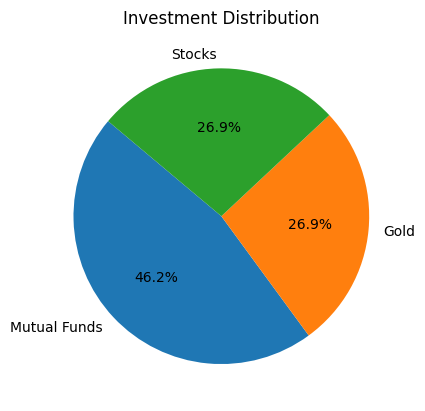

In [9]:
# Updated Breakdown: Now accounts for Mutual Fund Names and fixes the pie chart issue

import pandas as pd
import numpy as np
import yfinance as yf
import numpy_financial as npf
import matplotlib.pyplot as plt

# Load Mutual Fund Data, you will get from Keggle se
mutual_fund_data = pd.read_csv('/content/sample_data/comprehensive_mutual_funds_data.csv')

# Step 1: Get user input, as deviced earlier 15 inputs but abhi shuruat j to will take some limited inouts
def get_user_input():
    financial_goal = float(input("Enter your financial goal amount: "))
    goal_timeline_months = int(input("Enter goal timeline in months: "))
    risk_min = int(input("Enter your minimum risk tolerance (0-6): "))
    risk_max = int(input("Enter your maximum risk tolerance (0-6): "))
    monthly_income = float(input("Enter your current monthly income: "))
    monthly_expenses = float(input("Enter your monthly expenses: "))
    previous_savings = float(input("Enter your previous savings: "))

    return {
        "financial_goal": financial_goal,
        "goal_timeline_months": goal_timeline_months,
        "risk_min": risk_min,
        "risk_max": risk_max,
        "monthly_income": monthly_income,
        "monthly_expenses": monthly_expenses,
        "previous_savings": previous_savings
    }

# Step 2: Filter mutual funds based on risk tolerance, data basd on the dataset
def filter_mutual_funds(risk_min, risk_max):
    return mutual_fund_data[(mutual_fund_data['risk_level'] >= risk_min) &
                            (mutual_fund_data['risk_level'] <= risk_max)]

# Step 3: Select top 3 mutual funds
def select_top_mutual_funds(filtered_funds):
    # Sort funds by best 1-year returns and pick the top 3
    return filtered_funds.sort_values(by='returns_1yr', ascending=False).head(3)

# Step 4: Fetch live data for gold and stocks
def fetch_live_data():
    gold_data = yf.download("GC=F", start="2022-01-01", end="2023-01-01")
    stock_data = yf.download("^NSEI", period="6mo", interval="1d")  # NSE Nifty 50 index
    return gold_data, stock_data

# Step 5: Calculate expected returns
def calculate_expected_returns(top_funds, gold_data, stock_data):
    stock_returns = (stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0]) / stock_data['Close'].iloc[0] * 100
    gold_returns = (gold_data['Close'].iloc[-1] - gold_data['Close'].iloc[0]) / gold_data['Close'].iloc[0] * 100
    mutual_fund_returns = top_funds['returns_1yr'].mean()

    return mutual_fund_returns, stock_returns, gold_returns

# Step 6: Dynamic SIP Allocation for Mutual Funds and lump sum for stocks/gold
def sip_allocation(monthly_savings):
    mutual_fund_sip = np.random.uniform(0.40, 0.50) * monthly_savings
    remaining_savings = monthly_savings - mutual_fund_sip
    gold_investment = remaining_savings * 0.60
    stock_investment = remaining_savings * 0.40
    return mutual_fund_sip, gold_investment, stock_investment

# Step 7: Calculate future value of lump sum investments and monthly SIPs
def calculate_future_value(month, mutual_fund_sip, gold_investment, stock_investment, mutual_fund_returns, gold_returns, stock_returns):
    mutual_fund_future_value = npf.fv(mutual_fund_returns / 100 / 12, month, -mutual_fund_sip, 0)
    gold_future_value = npf.fv(gold_returns / 100 / 12, month, 0, -gold_investment)
    stock_future_value = npf.fv(stock_returns / 100 / 12, month, 0, -stock_investment)

    total_future_value = mutual_fund_future_value + gold_future_value + stock_future_value
    return total_future_value

# Step 8: Dynamic investment plan for monthly investments
def dynamic_investment_plan(user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns):
    monthly_savings = user_input['monthly_income'] - user_input['monthly_expenses']
    months = user_input['goal_timeline_months']
    total_future_value = 0

    # Cumulative values to track total SIPs for the pie chart
    total_mutual_fund_sip = 0
    total_gold_investment = 0
    total_stock_investment = 0

    # Calculate future value with monthly contributions
    for month in range(1, months + 1):
        mutual_fund_sip, gold_investment, stock_investment = sip_allocation(monthly_savings)
        total_future_value += calculate_future_value(month, mutual_fund_sip, gold_investment, stock_investment,
                                                     mutual_fund_returns, gold_returns, stock_returns)
        # Accumulate SIPs and investments for pie chart
        total_mutual_fund_sip += mutual_fund_sip
        total_gold_investment += gold_investment
        total_stock_investment += stock_investment

    # Show breakdown
    print(f"\n--- Monthly Investment Breakdown ---")
    print(f"Monthly Savings: ₹{monthly_savings:.2f}")
    print(f"Mutual Funds SIP: ₹{mutual_fund_sip:.2f}")
    print(f"Gold Investment: ₹{gold_investment:.2f}")
    print(f"Stock Investment: ₹{stock_investment:.2f}")
    print(f"Total Future Value: ₹{total_future_value:.2f}")

    return total_future_value, total_mutual_fund_sip, total_gold_investment, total_stock_investment

# Step 9: Generate a financial plan
def generate_financial_plan(user_input):
    # Filter mutual funds by risk and select top 3
    filtered_funds = filter_mutual_funds(user_input['risk_min'], user_input['risk_max'])
    top_funds = select_top_mutual_funds(filtered_funds)

    # Fetch gold and stock data
    gold_data, stock_data = fetch_live_data()

    # Calculate expected returns
    mutual_fund_returns, stock_returns, gold_returns = calculate_expected_returns(top_funds, gold_data, stock_data)

    # Get the future value based on dynamic allocation
    total_future_value, total_mutual_fund_sip, total_gold_investment, total_stock_investment = dynamic_investment_plan(
        user_input, top_funds, mutual_fund_returns, gold_returns, stock_returns)

    # Display financial plan results
    print(f"\nInitial capital: {user_input['previous_savings']:.2f}")
    print(f"Capital after {user_input['goal_timeline_months']} months of investments: ₹{total_future_value:.2f}")
    print(f"How close to target: {total_future_value / user_input['financial_goal'] * 100:.2f}%")

    # Display suggested mutual funds with SIPs
    print("\nSuggested Mutual Funds and SIP Amounts:")
    for idx, row in top_funds.iterrows():
        fund_allocation_percentage = row['returns_1yr'] / top_funds['returns_1yr'].sum()  # Distribute based on returns
        sip_amount = fund_allocation_percentage * total_mutual_fund_sip / user_input['goal_timeline_months']
        print(f"Scheme: {row['scheme_name']}, 1-Year Return: {row['returns_1yr']}%, SIP Amount: ₹{sip_amount:.2f}")

    # Visualization: Pie chart for investment distribution
    labels = ['Mutual Funds', 'Gold', 'Stocks']
    sizes = [total_mutual_fund_sip, total_gold_investment, total_stock_investment]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Investment Distribution')
    plt.show()

# Main function
def main():
    user_input = get_user_input()
    generate_financial_plan(user_input)

if __name__ == "__main__":
    main()
